## 0. Goal
Given latents of sliding windows on all call syllables, try different ways of UMAP. <br>
1. One call type only
2. A few call types
3. All call types

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc
import colorsys

plt.rcParams['pdf.fonttype'] = 42 

In [50]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

In [4]:
# a function to get n distinctive colors
def get_distinct_colors(n):
    hsv_colors = [(x / n, 0.7, 0.9) for x in range(n)]
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    return rgb_colors

In [5]:
# parameters for UMAP
# param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}

## 1. Inputs

In [6]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [1.5,7]
# what syllable to analyze
syl = ['v']
# what spectogram datasets to use
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what VAE run to use
vae_suffix = 'VAE1'
vae_run = 'traj_chop_32_2_32'
fd_vae = os.path.join(fd_data, birdID, 'Traj', vae_suffix, vae_run)
# where the VAE latents results are saved
apply_suffix = 'applySyl1'
apply_run = f'latent.{vae_run}'
fd_latent = os.path.join(fd_data, birdID, 'Traj', apply_suffix, apply_run)
print(fd_latent)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/latent.traj_chop_32_2_32


In [7]:
# where to save results
fd_save = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'callUMAPone')
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/callUMAPone


In [8]:
# grab the latent data and info
fns_latent = sorted(glob.glob(os.path.join(fd_latent, 'latentM.v*.csv')))
# read in all data
latent_all = OrderedDict()
info_all = OrderedDict()
v_all = []
for fn in fns_latent:
    v = os.path.basename(fn).split('.')[1]
    v_all.append(v)
    latent_all[v] = np.loadtxt(fn, delimiter=',')
    fn_info = os.path.join(os.path.dirname(fn), f'info.{v}.csv')
    info_all[v] = pd.read_csv(fn_info, index_col=0)

In [9]:
# grab the info on syllales
fn_merged = os.path.join(fd_latent, f'{birdID}.info_merged.csv')
info_syl = pd.read_csv(fn_merged, index_col=0)
# construct a unique syllable id
info_syl['syl_id'] = [f'{info_syl["fn_wav"][ii]}_{info_syl["s_idx"][ii]}' for ii in info_syl.index]
info_syl_reset = info_syl.reset_index()  # reset index for easy merging later

## 2. UMAP on one call type only

In [10]:
# how many syllables to include
num_syl = 300
# set a threshold to get confident cluster only 
hdbscan_thre = 0.9

(218194, 4) (218194, 21)
Counter({'v0': 218194})
2288
(406910, 4) (406910, 21)
Counter({'v1': 406910})
3798
Total syllable 3798. Pass threshold 2662. Sampled 300
(32493, 32) (32493, 21)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jul 20 16:20:07 2025 Construct fuzzy simplicial set
Sun Jul 20 16:20:07 2025 Finding Nearest Neighbors
Sun Jul 20 16:20:07 2025 Building RP forest with 14 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Jul 20 16:20:07 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:20:08 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:20:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:20:22 2025 Finished embedding
Sun Jul 20 16:20:26 2025 Worst tree score: 0.90911889
Sun Jul 20 16:20:26 2025 Mean tree score: 0.91138091
Sun Jul 20 16:20:26 2025 Best tree score: 0.91533561
Sun Jul 20 16:20:26 2025 Forward diversification reduced edges from 812325 to 214006
Sun Jul 20 16:20:26 2025 Reverse diversification reduced edges from 214006 to 214006
Sun Jul 20 16:20:26 2025 Degree pruning reduced edges from 225586 to 225586
Sun Jul 20 16:20:26 2025 Resorting data and graph based on tree order
Sun Jul 20 16:20:26 2025 Building and compiling search function
(151874, 4) (151874, 21)
Counter({'v2': 151874})
1658
Total syllable 1658. Pass threshold 1443. Sampled 300
(274

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:20:33 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:20:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:20:43 2025 Finished embedding
Sun Jul 20 16:20:47 2025 Worst tree score: 0.89642597
Sun Jul 20 16:20:47 2025 Mean tree score: 0.89889469
Sun Jul 20 16:20:47 2025 Best tree score: 0.90342815
Sun Jul 20 16:20:47 2025 Forward diversification reduced edges from 685500 to 169357
Sun Jul 20 16:20:47 2025 Reverse diversification reduced edges from 169357 to 169357
Sun Jul 20 16:20:47 2025 Degree pruning reduced edges from 178926 to 178926
Sun Jul 20 16:20:47 2025 Resorting data and graph based on tree order
Sun Jul 20 16:20:47 2025 Building and compiling search function
(119340, 4) (119340, 21)
Counter({'v3': 119340})
1796
Total syllable 1796. Pass threshold 1362. Sampled 300
(195

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:20:52 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:20:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:21:00 2025 Finished embedding
Sun Jul 20 16:21:03 2025 Worst tree score: 0.89450268
Sun Jul 20 16:21:03 2025 Mean tree score: 0.89756243
Sun Jul 20 16:21:03 2025 Best tree score: 0.90150857
Sun Jul 20 16:21:03 2025 Forward diversification reduced edges from 488875 to 120516
Sun Jul 20 16:21:03 2025 Reverse diversification reduced edges from 120516 to 120516
Sun Jul 20 16:21:03 2025 Degree pruning reduced edges from 127280 to 127280
Sun Jul 20 16:21:03 2025 Resorting data and graph based on tree order
Sun Jul 20 16:21:03 2025 Building and compiling search function
(248016, 4) (248016, 21)
Counter({'v4': 248016})
2421
Total syllable 2421. Pass threshold 1228. Sampled 300
(310

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Sun Jul 20 16:21:08 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:21:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:21:21 2025 Finished embedding
Sun Jul 20 16:21:25 2025 Worst tree score: 0.92303235
Sun Jul 20 16:21:25 2025 Mean tree score: 0.92602607
Sun Jul 20 16:21:25 2025 Best tree score: 0.92901980
Sun Jul 20 16:21:25 2025 Forward diversification reduced edges from 776625 to 207405
Sun Jul 20 16:21:25 2025 Reverse diversification reduced edges from 207405 to 207405
Sun Jul 20 16:21:25 2025 Degree pruning reduced edges from 217772 to 217772
Sun Jul 20 16:21:25 2025 Resorting data and graph based on tree order
Sun Jul 20 16:21:25 2025 Building and compiling search function
(155189, 4) (155189, 21)
Counter({'v5': 155189})
1519
Total syllable 1519. Pass threshold 1359. Sampled 300
(306

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:21:32 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:21:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:21:44 2025 Finished embedding
Sun Jul 20 16:21:48 2025 Worst tree score: 0.90462824
Sun Jul 20 16:21:48 2025 Mean tree score: 0.90989714
Sun Jul 20 16:21:48 2025 Best tree score: 0.91350610
Sun Jul 20 16:21:48 2025 Forward diversification reduced edges from 765950 to 196120
Sun Jul 20 16:21:48 2025 Reverse diversification reduced edges from 196120 to 196120
Sun Jul 20 16:21:48 2025 Degree pruning reduced edges from 205976 to 205976
Sun Jul 20 16:21:48 2025 Resorting data and graph based on tree order
Sun Jul 20 16:21:48 2025 Building and compiling search function
(712157, 4) (712157, 21)
Counter({'v6': 712157})
6658
Total syllable 6658. Pass threshold 1742. Sampled 300
(297

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Jul 20 16:21:53 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:21:55 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:21:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:22:06 2025 Finished embedding
Sun Jul 20 16:22:10 2025 Worst tree score: 0.89300936
Sun Jul 20 16:22:10 2025 Mean tree score: 0.89465143
Sun Jul 20 16:22:10 2025 Best tree score: 0.89740578
Sun Jul 20 16:22:10 2025 Forward diversification reduced edges from 744925 to 186254
Sun Jul 20 16:22:10 2025 Reverse diversification reduced edges from 186254 to 186254
Sun Jul 20 16:22:10 2025 Degree pruning reduced edges from 197024 to 197024
Sun Jul 20 16:22:10 2025 Resorting data and graph based on tree order
Sun Jul 20 16:22:10 2025 Building and compiling search function
(279536, 4) (279536, 21)
Counter({'v7': 279536})
3102
Total syllable 3102. Pass threshold 2094. Sampled 300
(278

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 16:22:16 2025 Finished Nearest Neighbor Search
Sun Jul 20 16:22:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 16:22:27 2025 Finished embedding
Sun Jul 20 16:22:31 2025 Worst tree score: 0.89641663
Sun Jul 20 16:22:31 2025 Mean tree score: 0.90108903
Sun Jul 20 16:22:31 2025 Best tree score: 0.90414405
Sun Jul 20 16:22:31 2025 Forward diversification reduced edges from 695575 to 176750
Sun Jul 20 16:22:31 2025 Reverse diversification reduced edges from 176750 to 176750
Sun Jul 20 16:22:31 2025 Degree pruning reduced edges from 186168 to 186168
Sun Jul 20 16:22:31 2025 Resorting data and graph based on tree order
Sun Jul 20 16:22:31 2025 Building and compiling search function


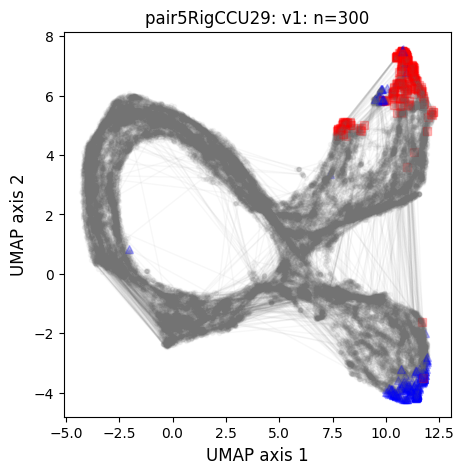

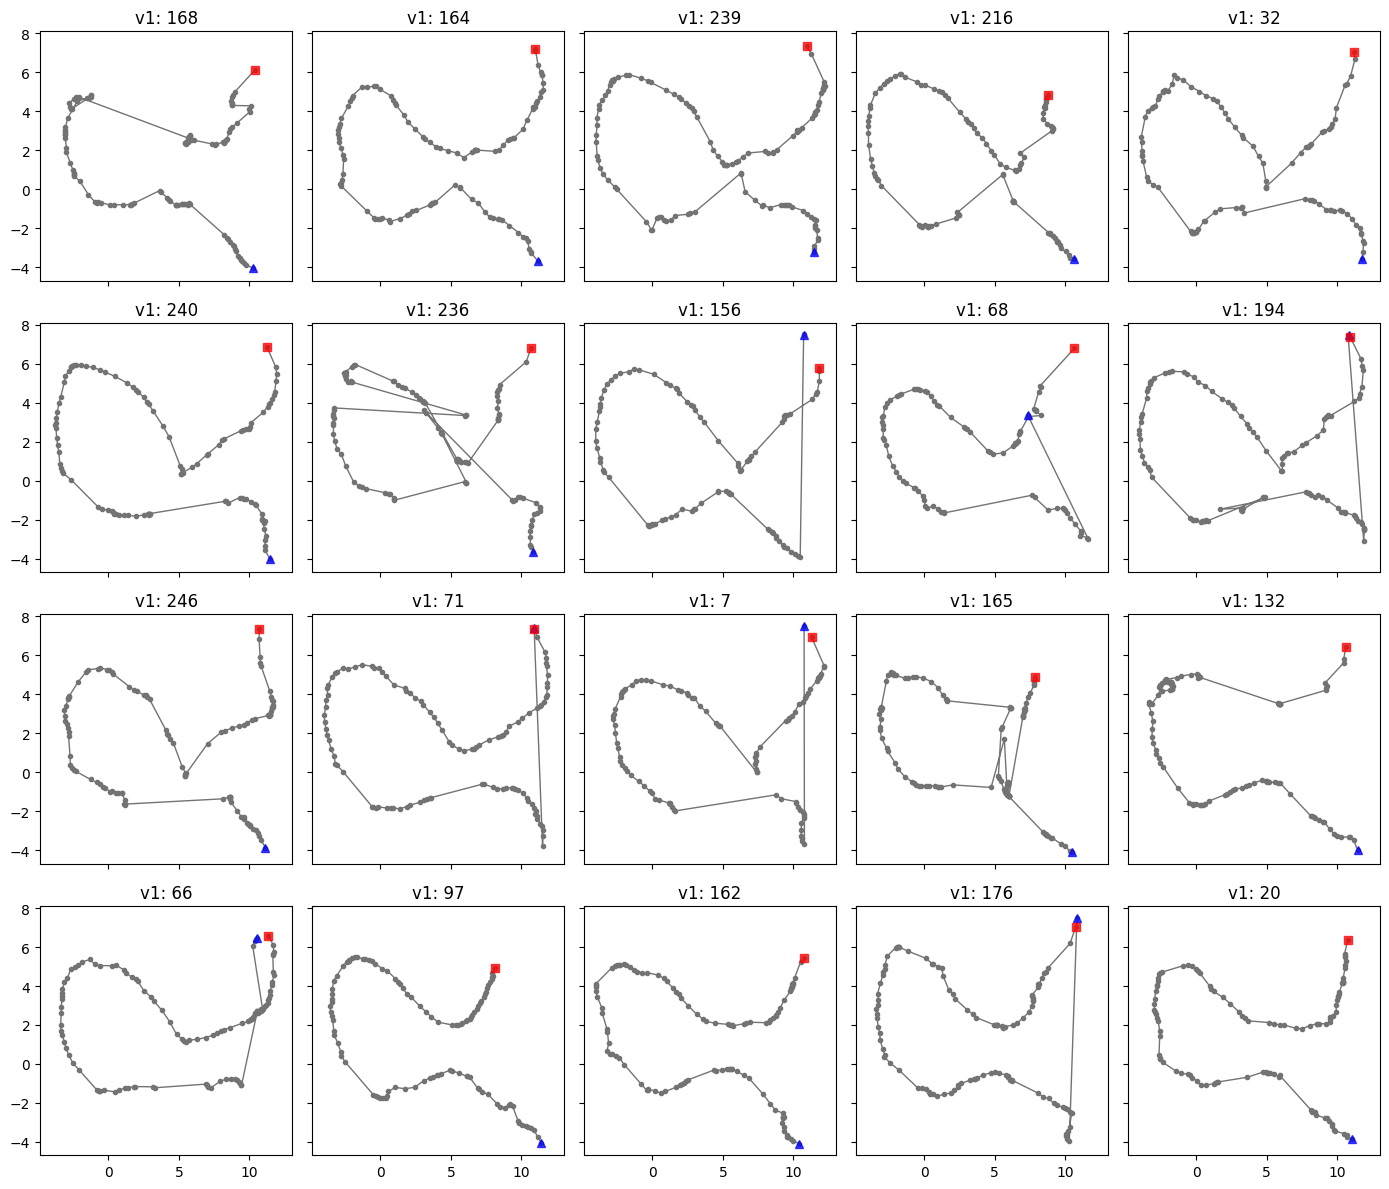

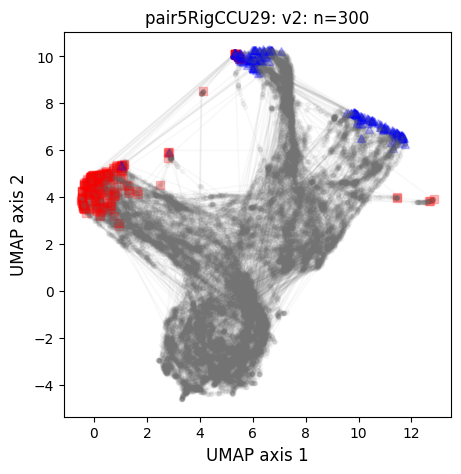

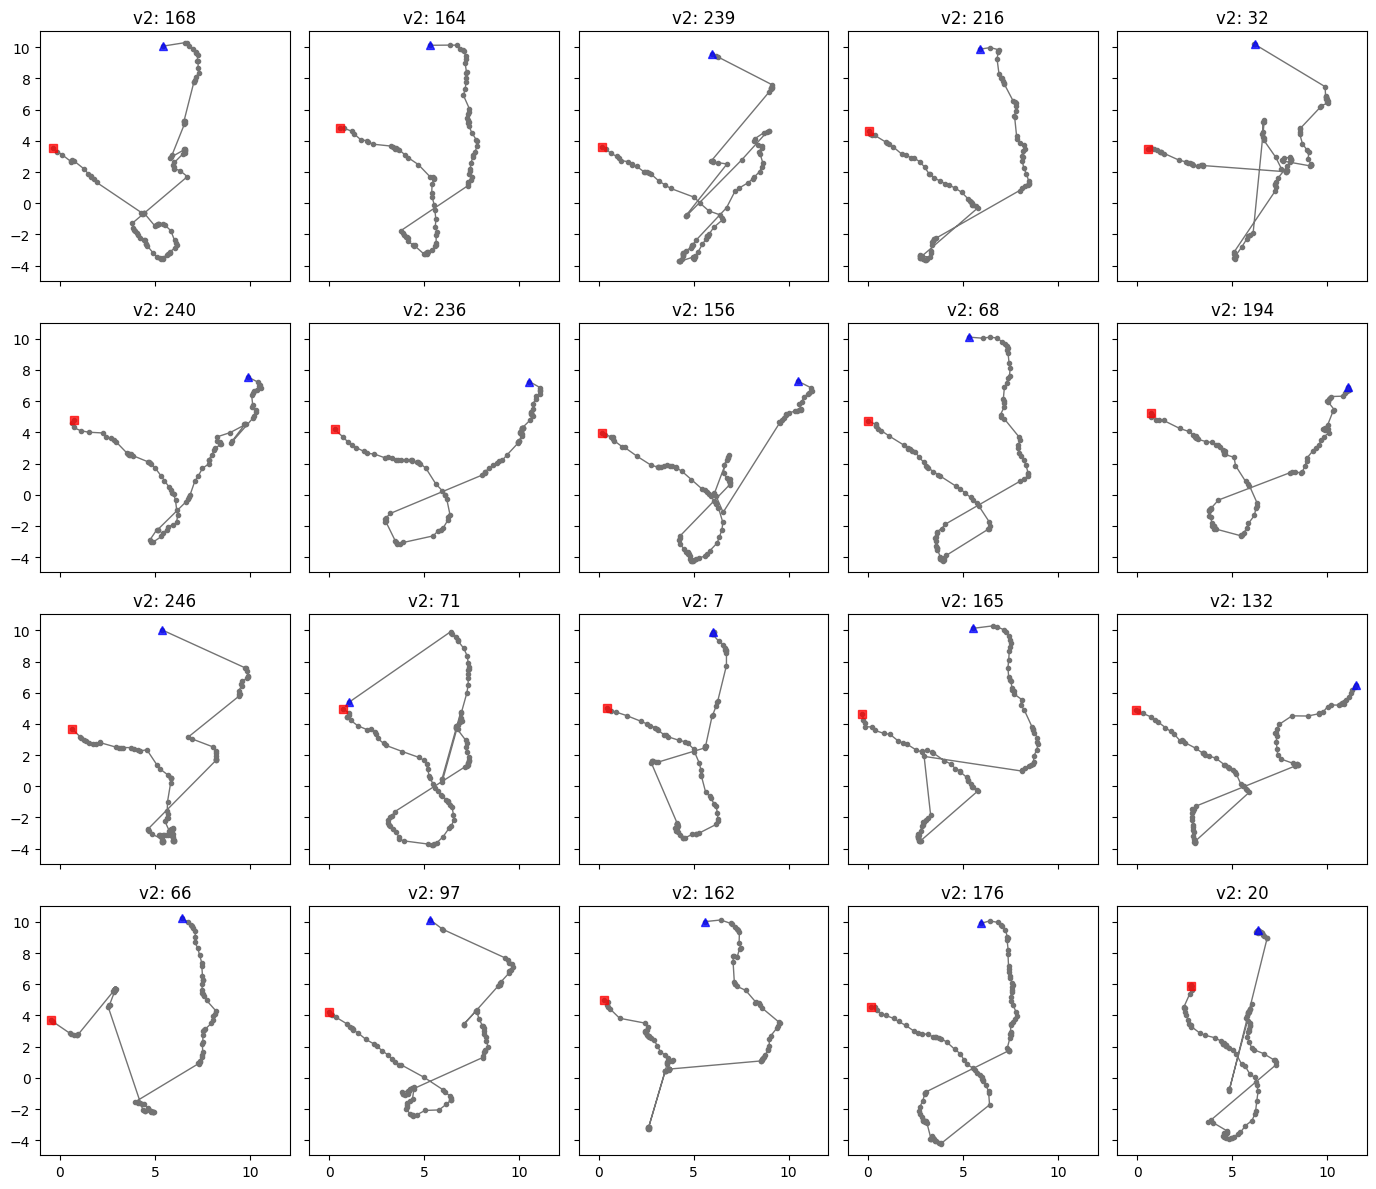

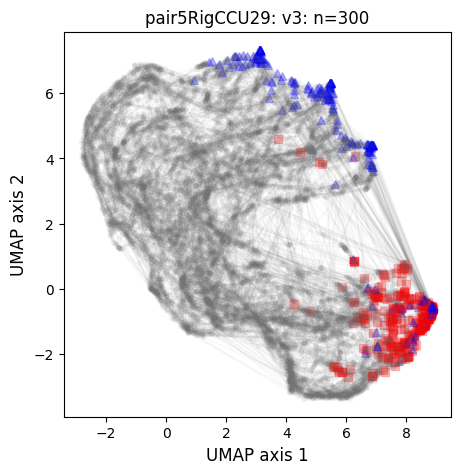

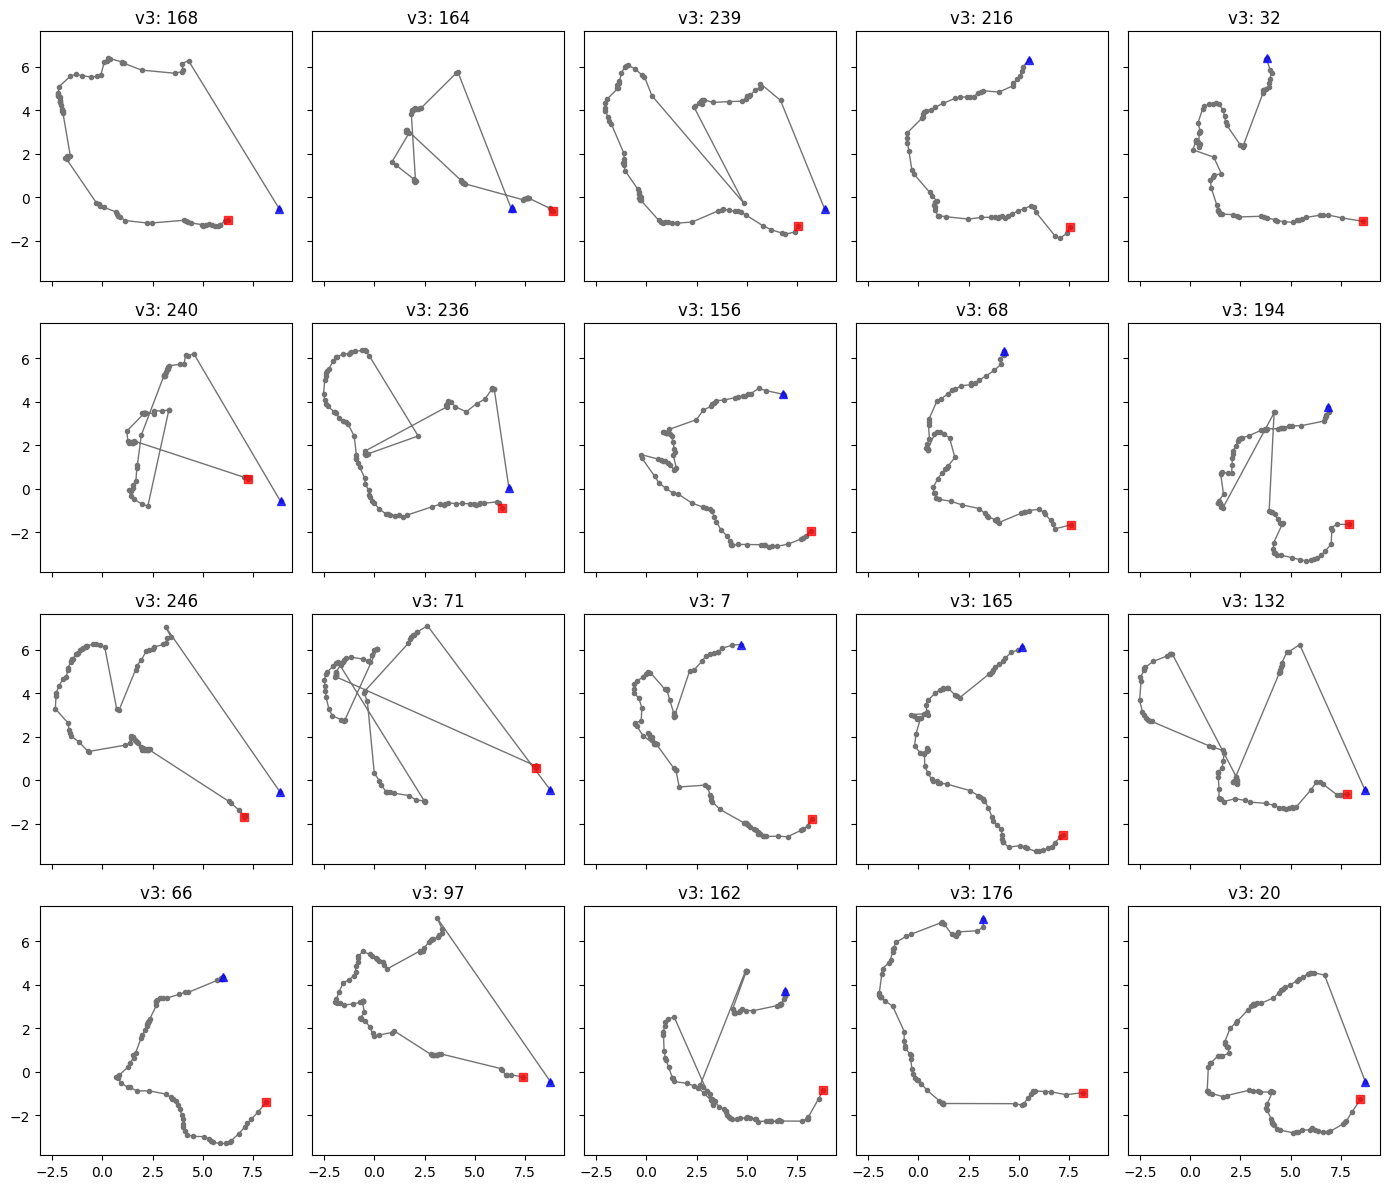

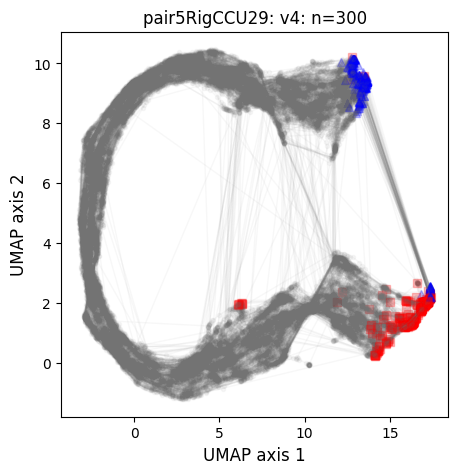

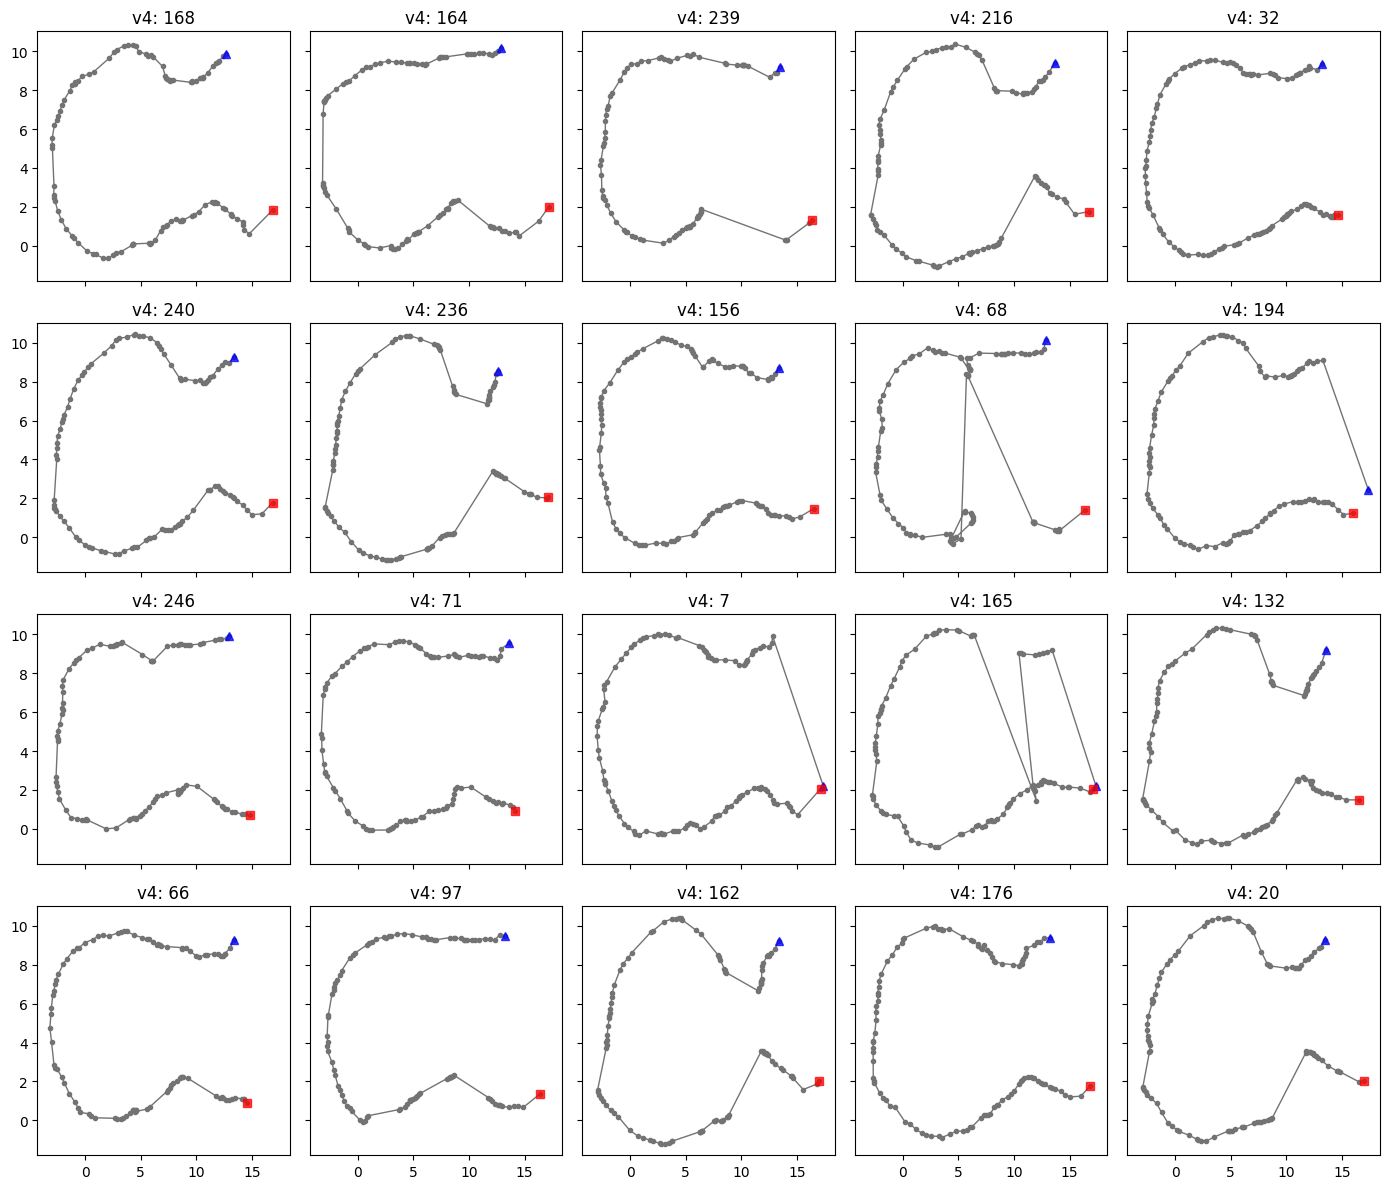

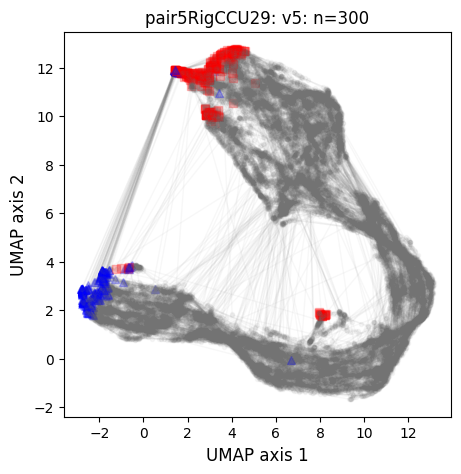

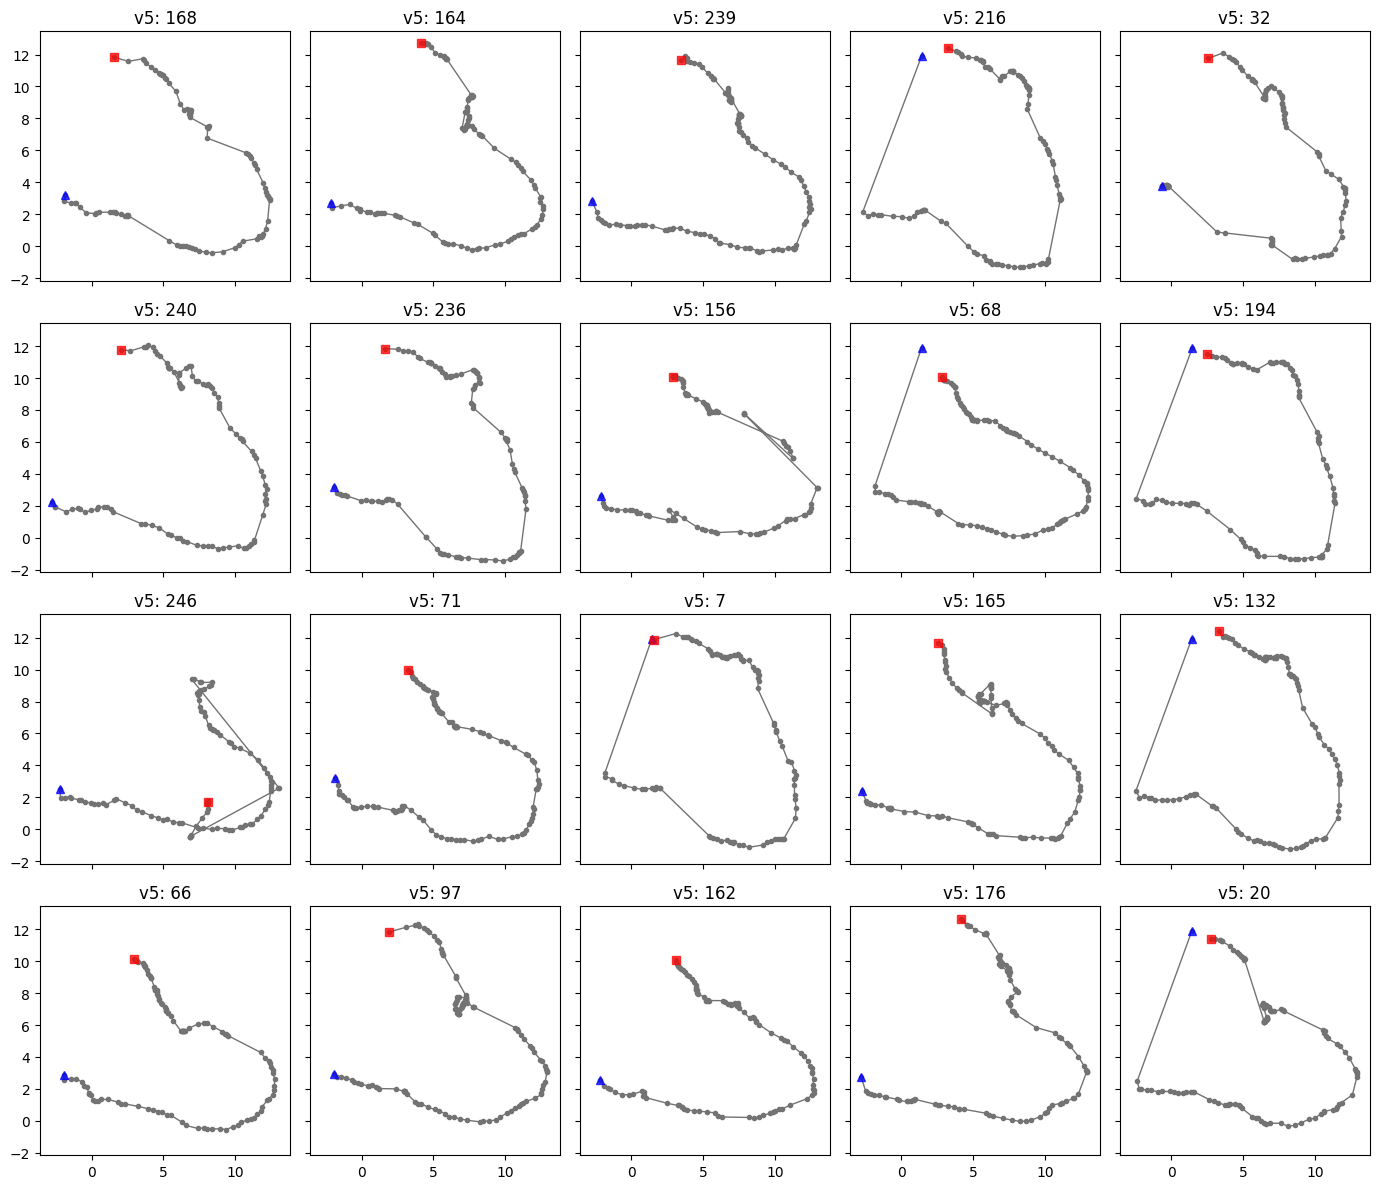

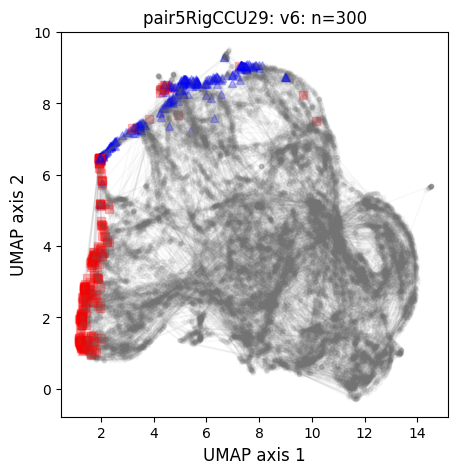

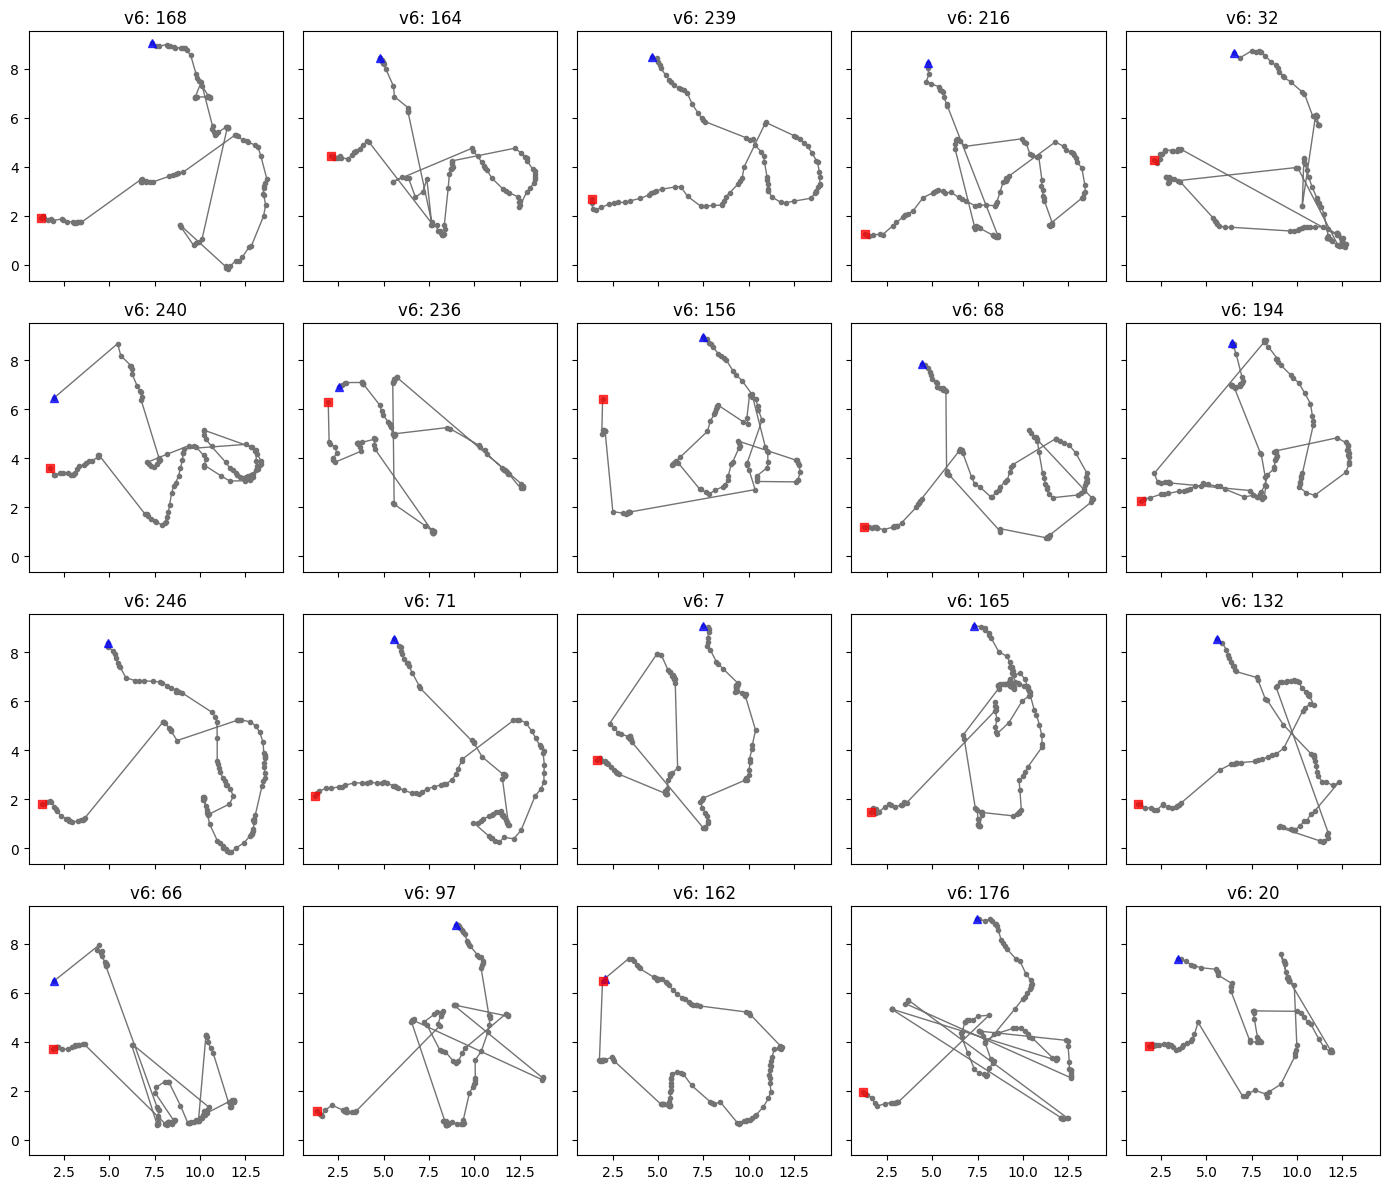

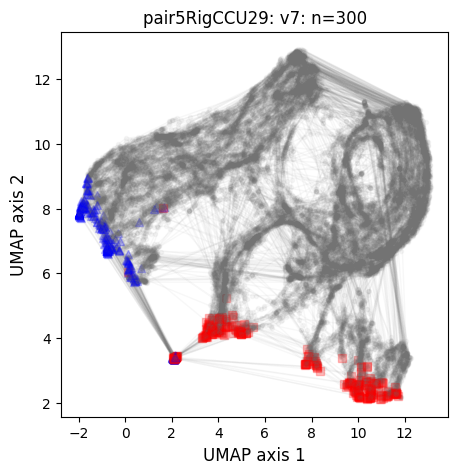

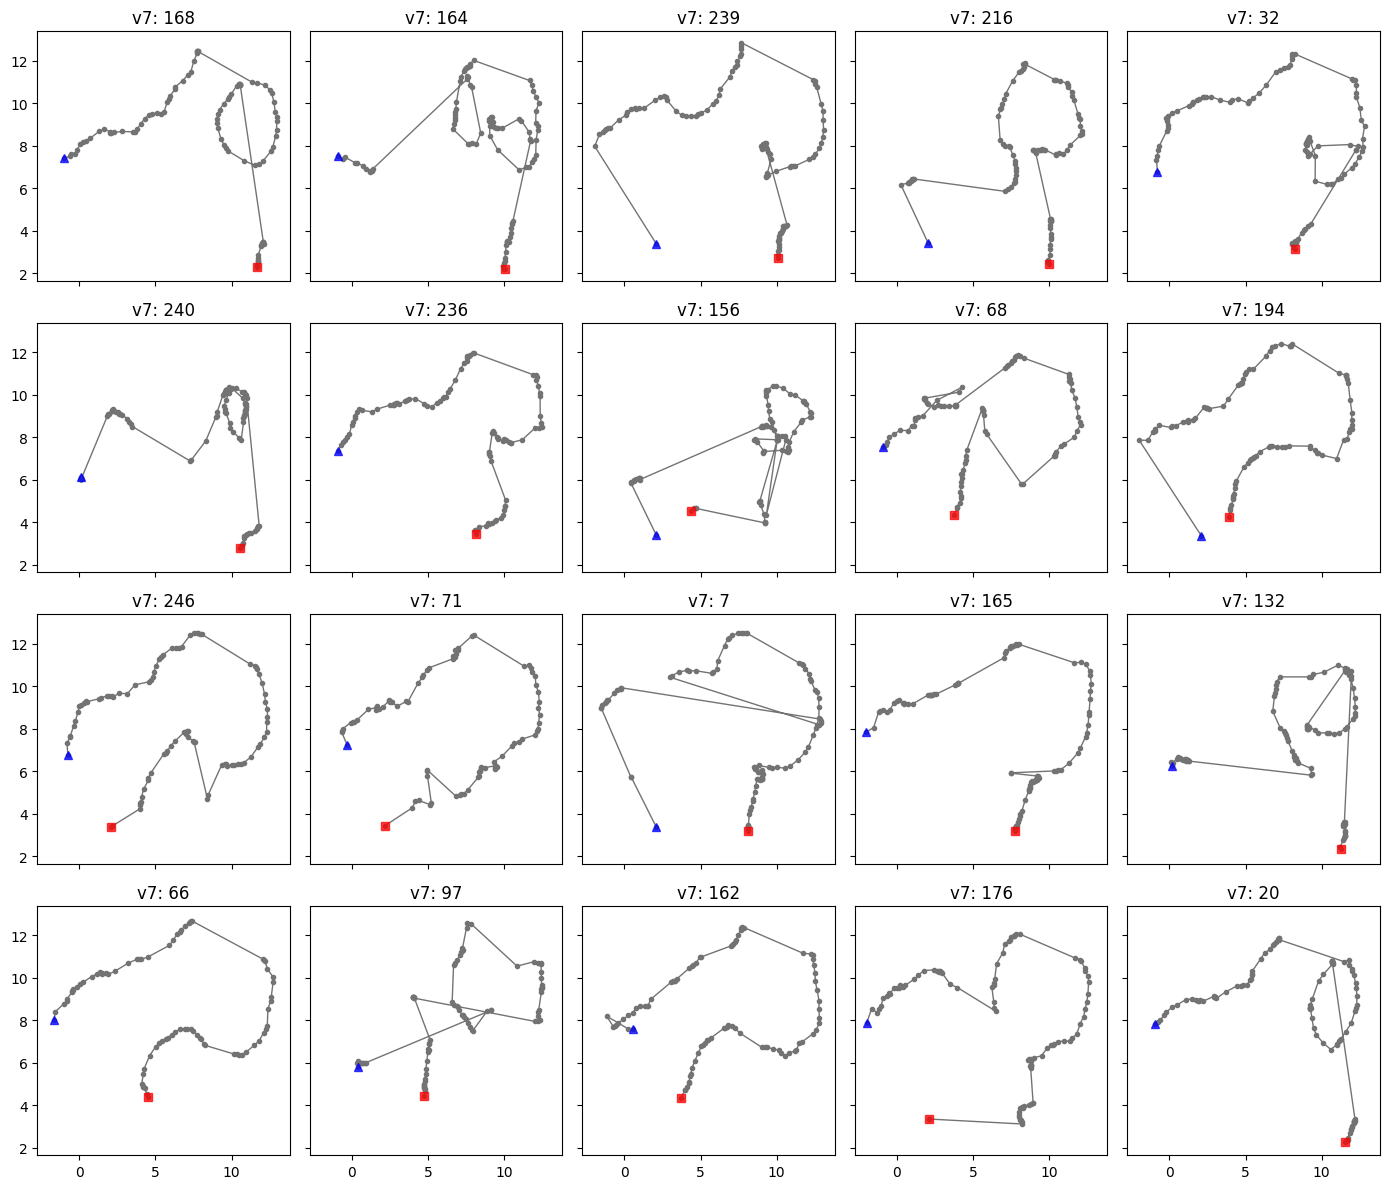

In [53]:
# v = 'v4'
for v in v_all:
    latent = latent_all[v]
    info = info_all[v]

    # merge the syllable info to sliding window info
    merged_info = info.merge(info_syl_reset, left_on='ri', right_on='index', how='left')
    print(info.shape, merged_info.shape)

    # some sanity check
    print(Counter(merged_info['call_subtype']))
    # does the syllable number match?
    print(len(set(merged_info['syl_id'])))

    #### sample data as UMAP inputs
    info_pass = merged_info[merged_info['hdbscan_prob']>=hdbscan_thre]
    if info_pass.empty:
        continue
    # get unique syllable id
    syl_uniq = list(set(info_pass['syl_id']))
    # same syllables
    num_sample = min([num_syl, len(syl_uniq)])
    print(f'Total syllable {len(set(merged_info["syl_id"]))}. Pass threshold {len(syl_uniq)}. Sampled {num_sample}')
    random.seed(1118)
    syl_rd = random.sample(syl_uniq, num_sample)

    # get the latent data
    iwin = merged_info[merged_info['syl_id'].isin(syl_rd)].index
    info_rd = merged_info.iloc[iwin, :]
    latent_rd = latent[iwin, :]
    print(latent_rd.shape, info_rd.shape)

    #### run the UMAP
    print(param_umap)
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    # put results in a master dataframe
    embed = info_rd.copy()
    for ii in range(latent_rd.shape[1]):
        embed[f'vae{ii}'] = latent_rd[:,ii]
    for jj in range(res.shape[1]):
        embed[f'umap{jj+1}'] = res[:,jj]

    # save the embedding
    fn_embed = os.path.join(fd_save, f'{birdID}.{v}.rd{num_syl}.embedding.csv')
    embed.to_csv(fn_embed)

    # save the UMAP model as well
    fn_umap = os.path.join(fd_save, f'{birdID}.{v}.rd{num_syl}.UMAPmodel.p')
    pickle.dump(umap_model, open(fn_umap, 'wb'))

    ## plot embedding: each syllable as one color
    # col_list = get_distinct_colors(len(syl_rd))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
    # for si, ss in enumerate(syl):
    # plot the X first
    for si in range(len(syl_rd)):
    # for si in range(2):
        ss = syl_rd[si]
        embed_s = embed[embed['syl_id']==ss]
        x = np.array(embed_s['umap1'])
        y = np.array(embed_s['umap2'])
        # ax.plot(x, y,  marker='o', linestyle='-', color=col_list[si], markersize=3, linewidth=1, alpha=0.1)
        ax.plot(x, y,  marker='o', linestyle='-', color='#737373', markersize=3, linewidth=1, alpha=0.05)
        # mark the start with triangle, and end with square
        ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.25)
        ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.25)
    # # add legend
    # legends = [Patch(facecolor=col, label=name) for col, name in zip(col_list, syl)]
    # plt.legend(handles=legends, loc='upper left')
    ax.set_title(f'{birdID}: {v}: n={len(syl_rd)}', fontsize=12)
    ax.set_xlabel('UMAP axis 1', fontsize=12)
    ax.set_ylabel('UMAP axis 2', fontsize=12)
    # plt.tight_layout()
    # save fig
    fn_fig =os.path.join(fd_save, f'{birdID}.{v}.rd{num_syl}.embedding.pdf')
    fig.savefig(fn_fig)

    ## plot each syllable in a subplot, sample 20 syllables
    # col_list = get_distinct_colors(len(syl_rd))
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=[14, 12], sharex=True, sharey=True)
    # for si, ss in enumerate(syl):
    # plot the X first
    to_sample = min([20, len(syl_rd)])
    random.seed(1992)
    to_plot = random.sample(range(len(syl_rd)), to_sample)
    for sii, si in enumerate(to_plot):
    # for si in range(2):
        if sii>=20:
            break
        plot_i = sii//5
        plot_j = sii%5
        ax = axes[plot_i][plot_j]
        ss = syl_rd[si]
        embed_s = embed[embed['syl_id']==ss]
        x = np.array(embed_s['umap1'])
        y = np.array(embed_s['umap2'])
        ax.plot(x, y,  marker='o', linestyle='-', color='#737373', markersize=3, linewidth=1)
        # mark the start with triangle, and end with square
        ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.75)
        ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.75)
        ax.set_title(f'{v}: {si}')
    plt.tight_layout()

    # save fig
    fn_fig = os.path.join(fd_save, f'{birdID}.{v}.rd{num_syl}.individual.pdf')
    fig.savefig(fn_fig)

## 3. UMAP on several call subtypes

In [11]:
# how many syllables to include
num_syl = 300
# set a threshold to get confident cluster only 
hdbscan_thre = 0.9

In [12]:
# where to save results
fd_save2 = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'callUMAPmulti')
if not os.path.exists(fd_save2):
    os.makedirs(fd_save2)
print(fd_save2)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/callUMAPmulti


In [13]:
# what call subtypes to analyze together
pairs = [['v4', 'v5'], ['v1', 'v7']] 

In [40]:
pi = 1
p = pairs[pi]

In [41]:
# load the latent, combine the data for UMAP
latent_comb = np.empty((0, 32))
info_comb = pd.DataFrame()
for v in p:
    latent = latent_all[v]
    info = info_all[v]
    
    # merge the syllable info to sliding window info
    merged_info = info.merge(info_syl_reset, left_on='ri', right_on='index', how='left')
    print(info.shape, merged_info.shape)
    
    #### sample data as UMAP inputs
    info_pass = merged_info[merged_info['hdbscan_prob']>=hdbscan_thre]
    if info_pass.empty:
        continue
    # get unique syllable id
    syl_uniq = list(set(info_pass['syl_id']))
    # same syllables
    num_sample = min([num_syl, len(syl_uniq)])
    print(f'Total syllable {len(set(merged_info["syl_id"]))}. Pass threshold {len(syl_uniq)}. Sampled {num_sample}')
    random.seed(1118)
    syl_rd = random.sample(syl_uniq, num_sample)

    # get the latent data
    iwin = merged_info[merged_info['syl_id'].isin(syl_rd)].index
    info_rd = merged_info.iloc[iwin, :]
    latent_rd = latent[iwin, :]
    print(latent_rd.shape, info_rd.shape)
    
    latent_comb = np.vstack([latent_comb, latent_rd])
    info_comb = pd.concat([info_comb, info_rd], ignore_index=True)

(406910, 4) (406910, 21)
Total syllable 3798. Pass threshold 2662. Sampled 300
(32389, 32) (32389, 21)
(279536, 4) (279536, 21)
Total syllable 3102. Pass threshold 2094. Sampled 300
(27790, 32) (27790, 21)


In [42]:
#### run the UMAP
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_comb)

# put results in a master dataframe
embed = info_comb.copy()
for ii in range(latent_rd.shape[1]):
    embed[f'vae{ii}'] = latent_comb[:,ii]
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

# save the embedding
syl_str = ''.join(p)
fn_embed = os.path.join(fd_save2, f'{birdID}.{syl_str}.rd{num_syl}.embedding.csv')
embed.to_csv(fn_embed)

# save the UMAP model as well
fn_umap = os.path.join(fd_save2, f'{birdID}.{syl_str}.rd{num_syl}.UMAPmodel.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jul 20 17:18:12 2025 Construct fuzzy simplicial set
Sun Jul 20 17:18:12 2025 Finding Nearest Neighbors
Sun Jul 20 17:18:12 2025 Building RP forest with 17 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Jul 20 17:18:12 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Jul 20 17:18:14 2025 Finished Nearest Neighbor Search
Sun Jul 20 17:18:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 20 17:18:39 2025 Finished embedding
Sun Jul 20 17:18:47 2025 Worst tree score: 0.88482693
Sun Jul 20 17:18:47 2025 Mean tree score: 0.88727747
Sun Jul 20 17:18:47 2025 Best tree score: 0.89016102
Sun Jul 20 17:18:47 2025 Forward diversification reduced edges from 1504475 to 408167
Sun Jul 20 17:18:47 2025 Reverse diversification reduced edges from 408167 to 408167
Sun Jul 20 17:18:47 2025 Degree pruning reduced edges from 434154 to 434154
Sun Jul 20 17:18:47 2025 Resorting data and graph based on tree order
Sun Jul 20 17:18:47 2025 Building and compiling search function


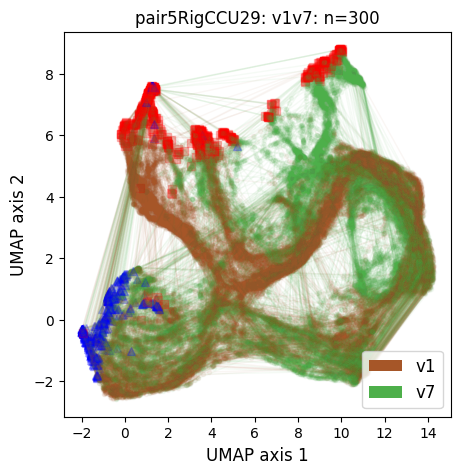

In [43]:
#### plot results, different color for different call subtypes
# col_list = get_distinct_colors(len(p))
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(p, col_full[0:len(p)]))
# get the syl id
syl_comb = list(set(info_comb['syl_id']))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
# for si, ss in enumerate(syl):
for si in range(len(syl_comb)):
# for si in range(2):
    ss = syl_comb[si]
    embed_s = embed[embed['syl_id']==ss]
    embed_s.index = range(embed_s.shape[0])
    x = np.array(embed_s['umap1'])
    y = np.array(embed_s['umap2'])
    v = embed_s['call_subtype'][0]
    # ax.plot(x, y,  marker='o', linestyle='-', color=col_list[si], markersize=3, linewidth=1, alpha=0.1)
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.05)
    # ax.plot(x, y,  'o', color=col_dict[v], markersize=3, alpha=0.05)
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.25)
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.25)
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax.legend(handles=legends, loc='lower right', fontsize=12)
ax.set_title(f'{birdID}: {syl_str}: n={num_syl}', fontsize=12)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
# # plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save2, f'{birdID}.{syl_str}.rd{num_syl}.embedding.pdf')
fig.savefig(fn_fig)

## 4. UMAP on all call subtypes

In [54]:
# where to save results
fd_save3 = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'callUMAPall')
if not os.path.exists(fd_save3):
    os.makedirs(fd_save3)
print(fd_save3)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/callUMAPall


In [53]:
# how many syllables to include
num_syl = 300
# set a threshold to get confident cluster only 
hdbscan_thre = 0.9

In [58]:
# load the latent, combine the data for UMAP
latent_comb = np.empty((0, 32))
info_comb = pd.DataFrame()
for v in v_all:
    latent = latent_all[v]
    info = info_all[v]
    
    # merge the syllable info to sliding window info
    merged_info = info.merge(info_syl_reset, left_on='ri', right_on='index', how='left')
    
    #### sample data as UMAP inputs
    info_pass = merged_info[merged_info['hdbscan_prob']>=hdbscan_thre]
    if info_pass.empty:
        continue
    # get unique syllable id
    syl_uniq = list(set(info_pass['syl_id']))
    # same syllables
    num_sample = min([num_syl, len(syl_uniq)])
    print(f'{v}: total syllable {len(set(merged_info["syl_id"]))}. Pass threshold {len(syl_uniq)}. Sampled {num_sample}')
    random.seed(1118)
    syl_rd = random.sample(syl_uniq, num_sample)

    # get the latent data
    iwin = merged_info[merged_info['syl_id'].isin(syl_rd)].index
    info_rd = merged_info.iloc[iwin, :]
    latent_rd = latent[iwin, :]
    print(latent_rd.shape, info_rd.shape)
    
    latent_comb = np.vstack([latent_comb, latent_rd])
    info_comb = pd.concat([info_comb, info_rd], ignore_index=True)

v1: total syllable 3798. Pass threshold 2662. Sampled 300
(32389, 32) (32389, 21)
v2: total syllable 1658. Pass threshold 1443. Sampled 300
(27485, 32) (27485, 21)
v3: total syllable 1796. Pass threshold 1362. Sampled 300
(19375, 32) (19375, 21)
v4: total syllable 2421. Pass threshold 1228. Sampled 300
(31035, 32) (31035, 21)
v5: total syllable 1519. Pass threshold 1359. Sampled 300
(30850, 32) (30850, 21)
v6: total syllable 6658. Pass threshold 1742. Sampled 300
(29805, 32) (29805, 21)
v7: total syllable 3102. Pass threshold 2094. Sampled 300
(27790, 32) (27790, 21)


In [60]:
print(latent_comb.shape, info_comb.shape)

(198729, 32) (198729, 21)


In [61]:
umap_model, embed = vae_goffinet.ZZ_runUMAP_v1(latent_comb, param_umap, random_state=1118, meta_info=info_comb)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jul 21 11:36:55 2025 Construct fuzzy simplicial set
Mon Jul 21 11:36:55 2025 Finding Nearest Neighbors
Mon Jul 21 11:36:55 2025 Building RP forest with 27 trees
Mon Jul 21 11:36:56 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 21 11:37:05 2025 Finished Nearest Neighbor Search
Mon Jul 21 11:37:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 21 11:38:48 2025 Finished embedding


In [88]:
# save the embedding
fn_embed = os.path.join(fd_save3, f'{birdID}.vAll.rd{num_syl}.embedding.csv')
embed.to_csv(fn_embed)

# save the UMAP model as well
fn_umap = os.path.join(fd_save3, f'{birdID}.vAll.rd{num_syl}.UMAPmodel.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Mon Jul 21 12:05:53 2025 Worst tree score: 0.84589063
Mon Jul 21 12:05:53 2025 Mean tree score: 0.84792262
Mon Jul 21 12:05:53 2025 Best tree score: 0.85038419
Mon Jul 21 12:05:53 2025 Forward diversification reduced edges from 4968225 to 1436655
Mon Jul 21 12:05:53 2025 Reverse diversification reduced edges from 1436655 to 1436655
Mon Jul 21 12:05:53 2025 Degree pruning reduced edges from 1556216 to 1556216
Mon Jul 21 12:05:53 2025 Resorting data and graph based on tree order
Mon Jul 21 12:05:53 2025 Building and compiling search function


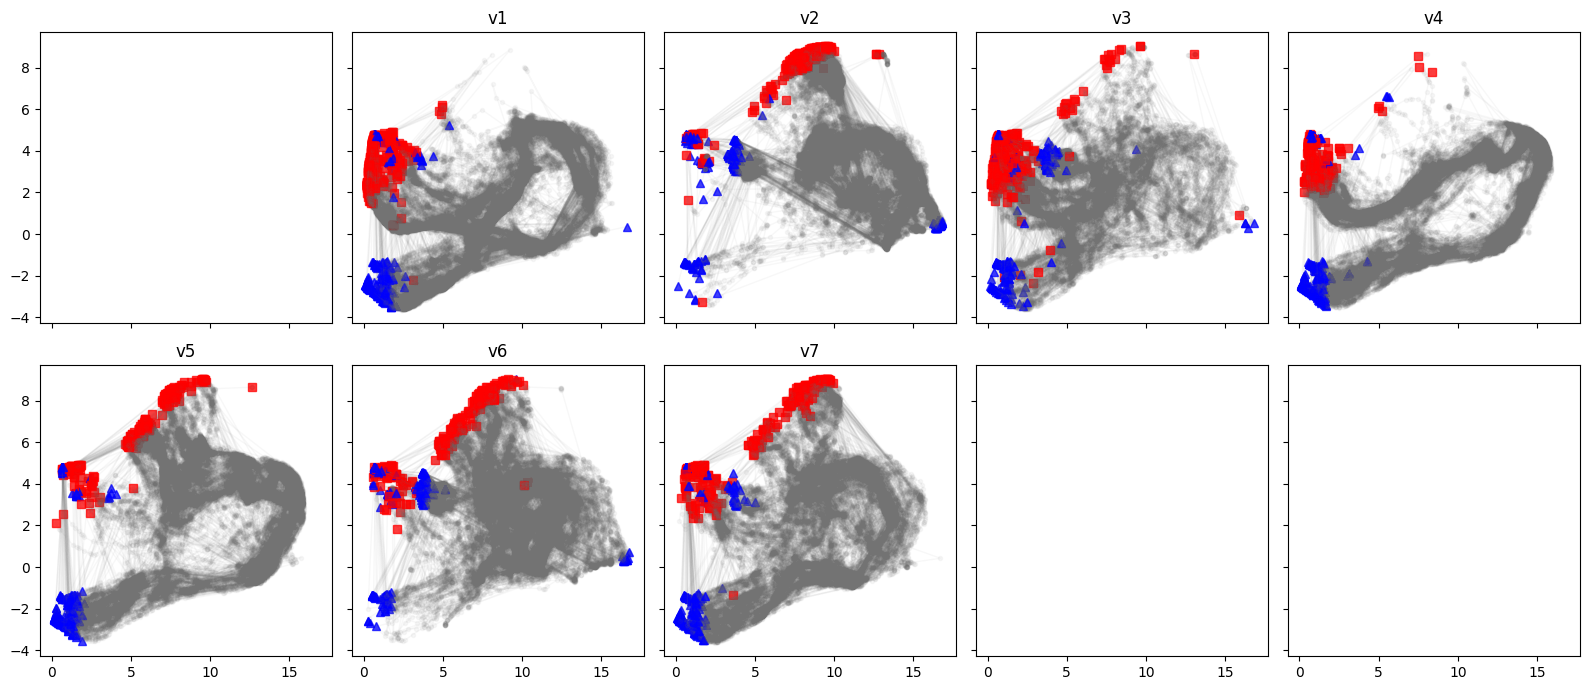

In [87]:
### plot, each call subtype one panel
# get all syllable id
syl_id = list(set(embed['syl_id']))
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[16, 7], sharex=True, sharey=True)
for sii in range(len(syl_id)):
# for sii in range(50):
    embed_s = embed[embed['syl_id']==syl_id[sii]]
    embed_s.index = range(embed_s.shape[0])
    v_this = embed_s['call_subtype'][0]
    v_i = v_all.index(v_this)
    plot_i = v_i//5
    plot_j = v_i%5
    ax = axes[plot_i][plot_j]
    x = np.array(embed_s['umap1'])
    y = np.array(embed_s['umap2'])
    ax.plot(x, y,  marker='o', linestyle='-', color='#737373', markersize=3, linewidth=1, alpha=0.05)
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.75)
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.75)
    ax.set_title(f'{v_this}')
plt.tight_layout()

# save fig
fn_fig = os.path.join(fd_save3, f'{birdID}.vAll.rd{num_syl}.pdf')
fig.savefig(fn_fig)